**Una aproximación mediante Ecuaciones Diferenciales Parciales (PDE) resuelto con un esquema de Euler–Maruyama para incluir ruido aditivo Y una simulación discreta estilo Gillespie**


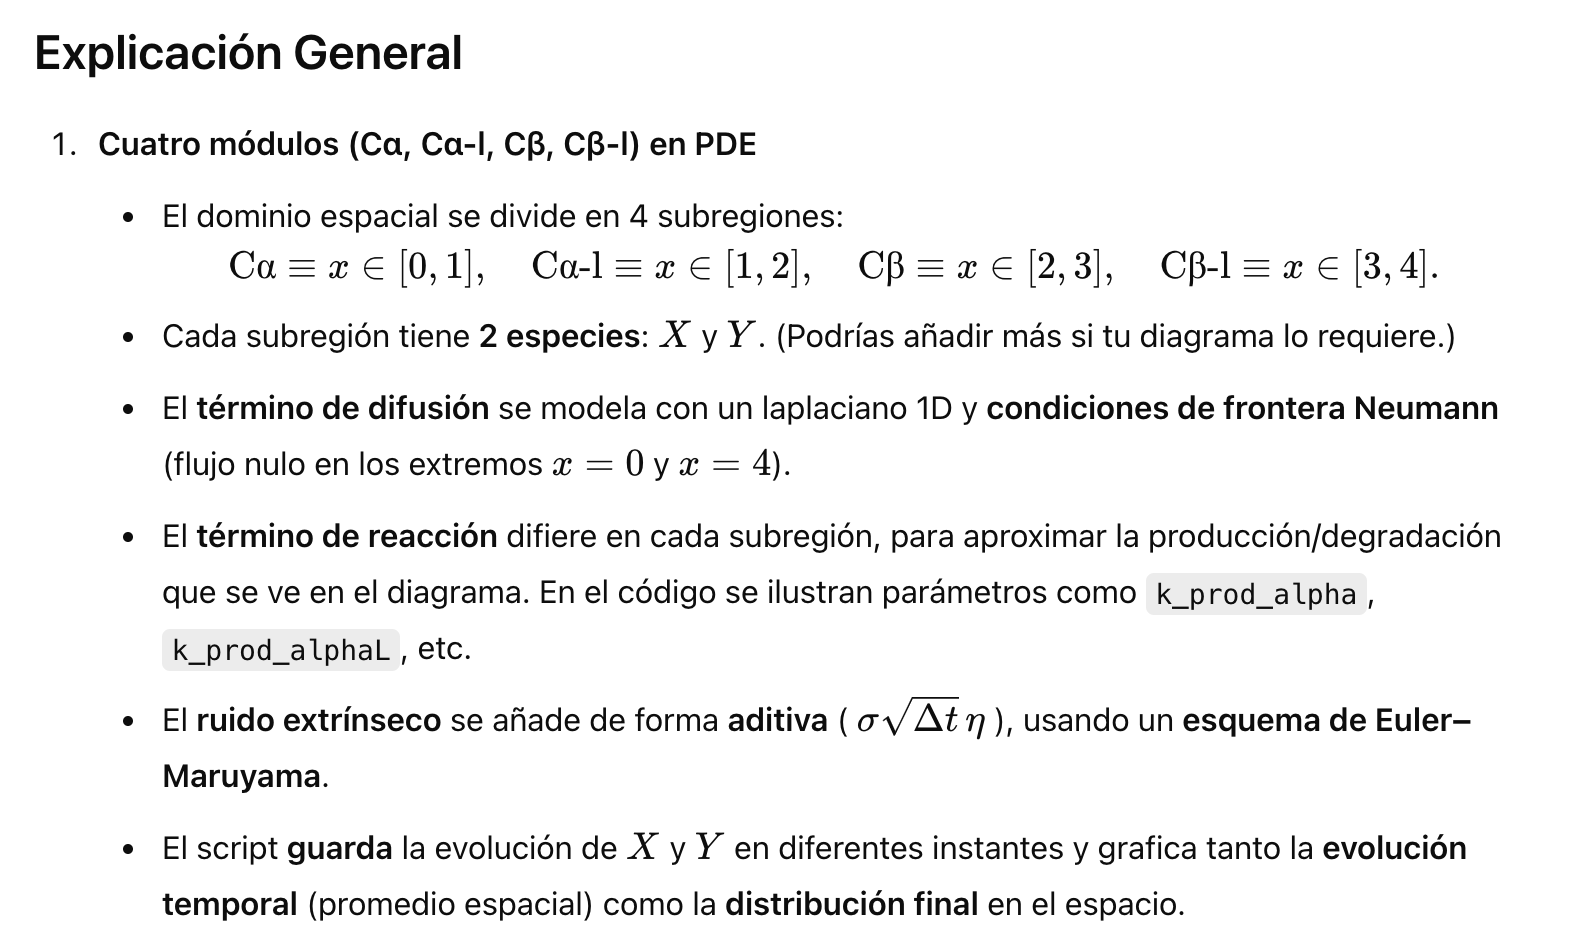

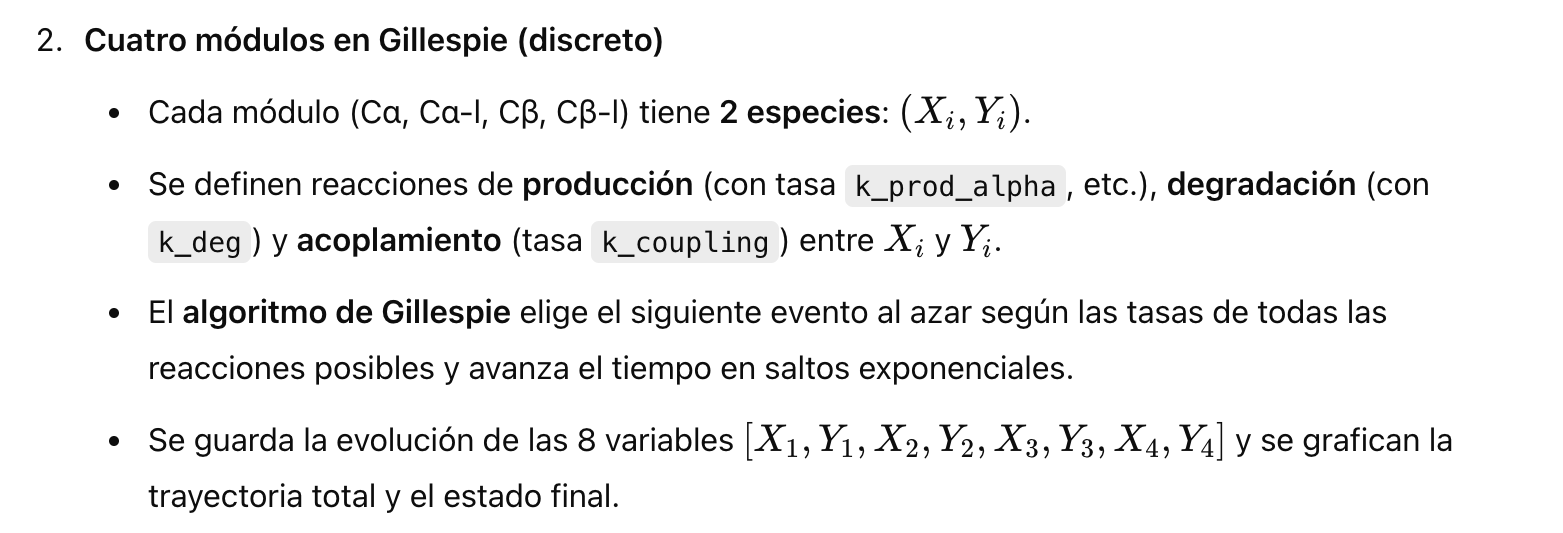

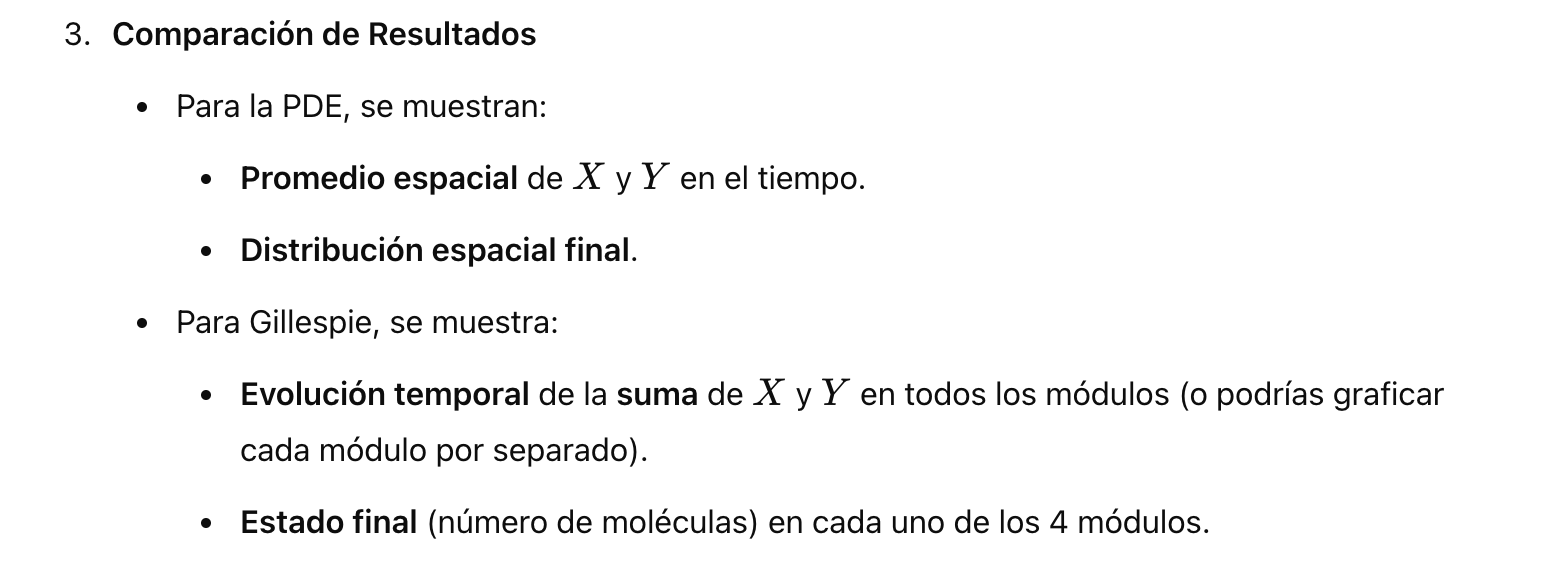

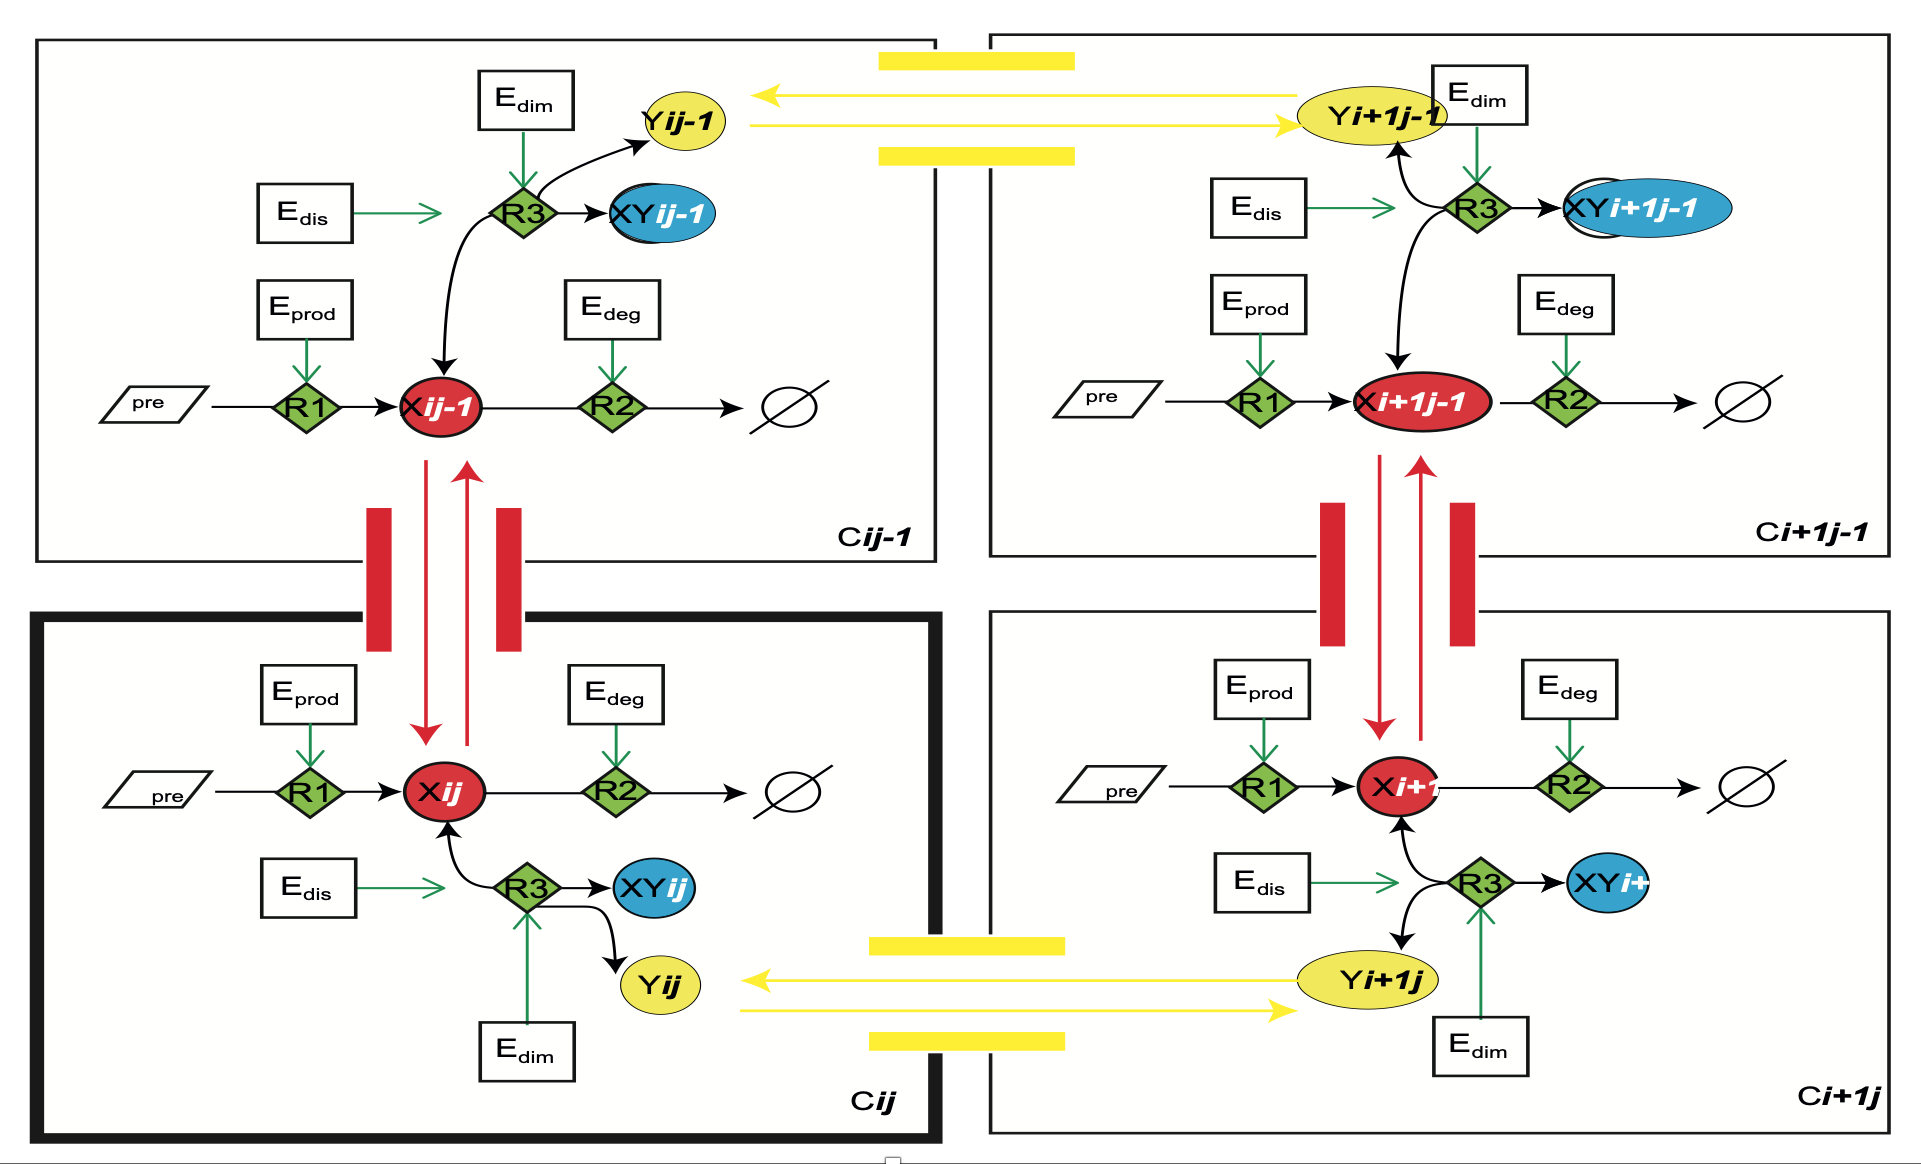

In [3]:
#!/usr/bin/env python
# coding: utf-8

"""
Ejemplo DEMOSTRATIVO en Python que aproxima un sistema de 4 módulos acoplados,
inspirado en un diagrama con compartimentos (Cα, Cα-l, Cβ, Cβ-l) y conexiones
entre ellos. Se incluyen:
 - Modelo PDE 1D con 4 subregiones (una por módulo).
 - Ruido extrínseco aditivo en el esquema de Euler–Maruyama.
 - Versión discreta tipo Gillespie para comparar.
 - Sliders (ipywidgets) para explorar parámetros.
 
NOTA: Ajustar ecuaciones y tasas para replicar fielmente el diagrama real.
"""

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
from scipy.integrate import odeint

# -------------------------------------------------------------------------
# 1) MODELO PDE 1D con 4 subregiones, cada una representa un módulo:
#    - Subregión 1 (x en [0,1]): Cα
#    - Subregión 2 (x en [1,2]): Cα-l
#    - Subregión 3 (x en [2,3]): Cβ
#    - Subregión 4 (x en [3,4]): Cβ-l
#    Cada subregión tiene 2 especies internas (por ejemplo, "X" e "Y"),
#    aunque puedes añadir más si tu diagrama lo requiere.
#    Se incluyen términos de reacción, acoplamiento entre subregiones
#    y ruido aditivo.
# -------------------------------------------------------------------------

def laplaciano_1D(u, dx, bc='neumann'):
    """
    Cálculo sencillo del laplaciano 1D con diferencias finitas y
    frontera de tipo Neumann (derivada nula) o Dirichlet (u=0).
    
    Args:
    - u: array 1D con la variable espacial
    - dx: paso espacial
    - bc: tipo de frontera ('neumann' o 'dirichlet')
    
    Return:
    - lap: array con la aproximación de la segunda derivada.
    """
    Nx = len(u)
    lap = np.zeros_like(u)
    
    for i in range(1, Nx-1):
        lap[i] = (u[i+1] - 2*u[i] + u[i-1]) / (dx**2)
    
    if bc == 'neumann':
        # derivada en el borde = 0 => aproximación
        lap[0] = (u[1] - u[0]) / (dx**2)
        lap[-1] = (u[-2] - u[-1]) / (dx**2)
    elif bc == 'dirichlet':
        # valor en el borde = 0 => u[0]=u[-1]=0
        lap[0] = 0
        lap[-1] = 0
    return lap

def pde_euler_maruyama_step(X, Y, dx, dt, D, sigma, reac_params):
    """
    Un paso de tiempo (dt) para dos especies X, Y en un dominio [0,4] con 4 subregiones.
    Se usa Euler–Maruyama: 
      U(t+dt) = U(t) + dt * F(U) + sqrt(dt)*sigma * N(0,1)
    
    Args:
    - X, Y: arrays 1D (longitud Nx) con la concentración de X e Y en cada punto espacial
    - dx, dt: paso espacial y temporal
    - D: coeficiente de difusión (asumimos igual para X y Y)
    - sigma: intensidad de ruido aditivo
    - reac_params: diccionario con parámetros de reacción y acoplamiento.
    
    Return:
    - X_next, Y_next: arrays actualizados tras un paso de tiempo.
    """
    Nx = len(X)
    
    # Separar las subregiones: 
    #   [0..1] => subregión 1 (Cα)
    #   [1..2] => subregión 2 (Cα-l)
    #   [2..3] => subregión 3 (Cβ)
    #   [3..4] => subregión 4 (Cβ-l)
    # Con Nx puntos en total, cada subregión ~ Nx/4 puntos (suponiendo Nx múltiplo de 4)
    seg = Nx // 4
    
    # Parámetros de reacción (ejemplo orientativo)
    # Ajustar según tu diagrama:
    k_prod_alpha  = reac_params['k_prod_alpha']   # producción X e Y en subregión α
    k_prod_alphaL = reac_params['k_prod_alphaL']  # producción X e Y en subregión α-l
    k_prod_beta   = reac_params['k_prod_beta']
    k_prod_betaL  = reac_params['k_prod_betaL']
    k_deg         = reac_params['k_deg']          # degradación
    k_coupling    = reac_params['k_coupling']     # factor de acoplamiento X->Y o Y->X (depende de tu diagrama)
    
    # Laplaciano para difusión
    lapX = laplaciano_1D(X, dx, bc='neumann')
    lapY = laplaciano_1D(Y, dx, bc='neumann')
    
    # Construimos un término de reacción R(X,Y) distinto por subregión.
    # Ejemplo:
    #   subregión α: dX/dt = k_prod_alpha - k_deg*X + (algo de acoplamiento con Y?)
    #   subregión α-l: etc.
    # Este es un esquema genérico. Ajusta a tu circuito.
    R_X = np.zeros(Nx)
    R_Y = np.zeros(Nx)
    
    # Subregión 1: Cα
    R_X[0:seg] = k_prod_alpha - k_deg*X[0:seg] + k_coupling*(Y[0:seg] - X[0:seg])
    R_Y[0:seg] = k_prod_alpha - k_deg*Y[0:seg] + k_coupling*(X[0:seg] - Y[0:seg])
    
    # Subregión 2: Cα-l
    R_X[seg:2*seg] = k_prod_alphaL - k_deg*X[seg:2*seg] + k_coupling*(Y[seg:2*seg] - X[seg:2*seg])
    R_Y[seg:2*seg] = k_prod_alphaL - k_deg*Y[seg:2*seg] + k_coupling*(X[seg:2*seg] - Y[seg:2*seg])
    
    # Subregión 3: Cβ
    R_X[2*seg:3*seg] = k_prod_beta - k_deg*X[2*seg:3*seg] + k_coupling*(Y[2*seg:3*seg] - X[2*seg:3*seg])
    R_Y[2*seg:3*seg] = k_prod_beta - k_deg*Y[2*seg:3*seg] + k_coupling*(X[2*seg:3*seg] - Y[2*seg:3*seg])
    
    # Subregión 4: Cβ-l
    R_X[3*seg:4*seg] = k_prod_betaL - k_deg*X[3*seg:4*seg] + k_coupling*(Y[3*seg:4*seg] - X[3*seg:4*seg])
    R_Y[3*seg:4*seg] = k_prod_betaL - k_deg*Y[3*seg:4*seg] + k_coupling*(X[3*seg:4*seg] - Y[3*seg:4*seg])
    
    # Difusión
    diffX = D * lapX
    diffY = D * lapY
    
    # Ruido aditivo
    noiseX = sigma * np.random.normal(0, 1, Nx)
    noiseY = sigma * np.random.normal(0, 1, Nx)
    
    # Euler–Maruyama
    X_next = X + dt*(diffX + R_X) + np.sqrt(dt)*noiseX
    Y_next = Y + dt*(diffY + R_Y) + np.sqrt(dt)*noiseY
    
    # Impedir valores negativos
    X_next[X_next<0] = 0
    Y_next[Y_next<0] = 0
    
    return X_next, Y_next

def simulate_pde_4modules(Nx=80, D=0.1, sigma=0.2, dt=0.01, T=2.0, reac_params=None):
    """
    Simula el modelo PDE con 4 subregiones (Cα, Cα-l, Cβ, Cβ-l) para 2 especies (X, Y).
    Usa el esquema Euler–Maruyama con paso dt, hasta tiempo T.
    
    Args:
    - Nx: número total de puntos espaciales en [0,4]
    - D: coeficiente de difusión
    - sigma: intensidad de ruido aditivo
    - dt: paso de tiempo
    - T: tiempo final
    - reac_params: diccionario con parámetros de reacción:
        {
         'k_prod_alpha', 'k_prod_alphaL', 'k_prod_beta', 'k_prod_betaL',
         'k_deg', 'k_coupling'
        }
    
    Return:
    - x: array de posiciones espaciales
    - t_array: array de tiempos guardados
    - X_sol, Y_sol: listas de arrays con la evolución de X e Y (en instantes guardados)
    """
    if reac_params is None:
        reac_params = {
            'k_prod_alpha': 1.0,
            'k_prod_alphaL': 1.0,
            'k_prod_beta': 1.0,
            'k_prod_betaL': 1.0,
            'k_deg': 0.5,
            'k_coupling': 0.2
        }
    L = 4.0  # dominio [0,4] para las 4 subregiones
    x = np.linspace(0, L, Nx)
    
    steps = int(T/dt)
    
    # Condiciones iniciales: 
    # Por ejemplo, X e Y ~ 0 al principio, salvo pequeños valores aleatorios
    X = 0.1 + 0.05*np.random.rand(Nx)
    Y = 0.1 + 0.05*np.random.rand(Nx)
    
    # Listas para guardar soluciones
    X_sol = [X.copy()]
    Y_sol = [Y.copy()]
    t_array = [0.0]
    
    save_interval = max(1, steps//50)  # guardamos ~50 snapshots
    
    for s in range(1, steps+1):
        X, Y = pde_euler_maruyama_step(X, Y, (L/(Nx-1)), dt, D, sigma, reac_params)
        if s % save_interval == 0:
            X_sol.append(X.copy())
            Y_sol.append(Y.copy())
            t_array.append(s*dt)
    
    return x, np.array(t_array), X_sol, Y_sol

# -------------------------------------------------------------------------
# 2) MODELO ESTILO GILLESPIE (discreto) para 4 módulos
#    Cada módulo tiene X_i, Y_i. Definimos reacciones de producción,
#    degradación y acoplamiento entre X_i y Y_i, inspiradas en la PDE.
# -------------------------------------------------------------------------

def gillespie_4modules(IC, reac_params, steps=1000):
    """
    Simula un sistema discreto de 4 módulos, cada uno con 2 especies: (X_i, Y_i).
    Reacciones:
      - Producción: k_prod modulo i
      - Degradación: k_deg * X_i (o Y_i)
      - Acoplamiento X_i <-> Y_i con tasa k_coupling, etc.
    
    IC: [X1, Y1, X2, Y2, X3, Y3, X4, Y4] estado inicial (enteros)
    reac_params: igual que en PDE, con k_prod_alpha, etc.
    steps: número de eventos Gillespie
    
    Return:
    - t_vec: tiempos de cada evento
    - states: array (steps+1, 8) con la evolución de [X1,Y1,X2,Y2,X3,Y3,X4,Y4]
    """
    import random
    
    # Convertimos a float por seguridad (aunque sean enteros)
    state = np.array(IC, dtype=float)
    t = 0.0
    
    t_vec = [t]
    states = [state.copy()]
    
    # Extraemos parámetros
    k_prod_alpha   = reac_params['k_prod_alpha']
    k_prod_alphaL  = reac_params['k_prod_alphaL']
    k_prod_beta    = reac_params['k_prod_beta']
    k_prod_betaL   = reac_params['k_prod_betaL']
    k_deg          = reac_params['k_deg']
    k_coupling     = reac_params['k_coupling']
    
    for _ in range(steps):
        # state = [X1, Y1, X2, Y2, X3, Y3, X4, Y4]
        X1, Y1, X2, Y2, X3, Y3, X4, Y4 = state
        
        # Tasas de producción en cada módulo (X e Y) => 8 posibles "producciones"
        # Módulo 1 (Cα): k_prod_alpha
        # Módulo 2 (Cα-l): k_prod_alphaL
        # Módulo 3 (Cβ): k_prod_beta
        # Módulo 4 (Cβ-l): k_prod_betaL
        
        # Producciones:
        r_prod = [
            k_prod_alpha,  # produce X1
            k_prod_alpha,  # produce Y1
            k_prod_alphaL, # produce X2
            k_prod_alphaL, # produce Y2
            k_prod_beta,   # produce X3
            k_prod_beta,   # produce Y3
            k_prod_betaL,  # produce X4
            k_prod_betaL   # produce Y4
        ]
        
        # Degradaciones: k_deg * Xi, k_deg * Yi
        r_deg = [
            k_deg * X1,
            k_deg * Y1,
            k_deg * X2,
            k_deg * Y2,
            k_deg * X3,
            k_deg * Y3,
            k_deg * X4,
            k_deg * Y4
        ]
        
        # Acoplamientos X_i <-> Y_i en cada módulo
        # Por ejemplo, X1 -> Y1 con tasa k_coupling * X1
        #             Y1 -> X1 con tasa k_coupling * Y1
        # Repetimos para los 4 módulos
        r_coup = [
            k_coupling * X1,  # X1 -> Y1
            k_coupling * Y1,  # Y1 -> X1
            k_coupling * X2,
            k_coupling * Y2,
            k_coupling * X3,
            k_coupling * Y3,
            k_coupling * X4,
            k_coupling * Y4
        ]
        
        all_rates = np.array(r_prod + r_deg + r_coup)
        total_rate = np.sum(all_rates)
        
        if total_rate <= 1e-12:
            # Si no hay eventos, se detiene
            break
        
        dt = np.random.exponential(1.0 / total_rate)
        t += dt
        
        # Elegimos cuál evento ocurre
        probs = all_rates / total_rate
        event_index = np.argmax(np.random.rand() <= np.cumsum(probs))
        
        # Actualizamos estado según el evento
        # 0..7 => producciones, 8..15 => degradaciones, 16..23 => acoplamientos
        if event_index < 8:
            # Producción
            if event_index == 0:  # produce X1
                X1 += 1
            elif event_index == 1:  # produce Y1
                Y1 += 1
            elif event_index == 2:  # produce X2
                X2 += 1
            elif event_index == 3:  # produce Y2
                Y2 += 1
            elif event_index == 4:  # produce X3
                X3 += 1
            elif event_index == 5:  # produce Y3
                Y3 += 1
            elif event_index == 6:  # produce X4
                X4 += 1
            elif event_index == 7:  # produce Y4
                Y4 += 1
        elif event_index < 16:
            # Degradación
            idx_deg = event_index - 8
            # idx_deg va de 0..7 => degrade X1, Y1, X2, Y2, ...
            if idx_deg == 0 and X1>0:
                X1 -= 1
            elif idx_deg == 1 and Y1>0:
                Y1 -= 1
            elif idx_deg == 2 and X2>0:
                X2 -= 1
            elif idx_deg == 3 and Y2>0:
                Y2 -= 1
            elif idx_deg == 4 and X3>0:
                X3 -= 1
            elif idx_deg == 5 and Y3>0:
                Y3 -= 1
            elif idx_deg == 6 and X4>0:
                X4 -= 1
            elif idx_deg == 7 and Y4>0:
                Y4 -= 1
        else:
            # Acoplamiento
            idx_coup = event_index - 16
            # 0-> X1->Y1, 1-> Y1->X1, 2-> X2->Y2, 3-> Y2->X2, ...
            if idx_coup == 0 and X1>0:
                X1 -= 1
                Y1 += 1
            elif idx_coup == 1 and Y1>0:
                Y1 -= 1
                X1 += 1
            elif idx_coup == 2 and X2>0:
                X2 -= 1
                Y2 += 1
            elif idx_coup == 3 and Y2>0:
                Y2 -= 1
                X2 += 1
            elif idx_coup == 4 and X3>0:
                X3 -= 1
                Y3 += 1
            elif idx_coup == 5 and Y3>0:
                Y3 -= 1
                X3 += 1
            elif idx_coup == 6 and X4>0:
                X4 -= 1
                Y4 += 1
            elif idx_coup == 7 and Y4>0:
                Y4 -= 1
                X4 += 1
        
        state = np.array([X1, Y1, X2, Y2, X3, Y3, X4, Y4], dtype=float)
        t_vec.append(t)
        states.append(state.copy())
    
    return np.array(t_vec), np.array(states)

# -------------------------------------------------------------------------
# 3) FUNCIONES DE GRAFICADO
# -------------------------------------------------------------------------

def run_simulation_and_plot(
    Nx=80, D=0.1, sigma=0.2, dt=0.01, T=2.0, 
    k_prod_alpha=1.0, k_prod_alphaL=1.0, k_prod_beta=1.0, k_prod_betaL=1.0,
    k_deg=0.5, k_coupling=0.2,
    steps_g=500
):
    """
    Corre la simulación PDE con 4 subregiones y la simulación Gillespie con 4 módulos,
    y genera gráficos comparativos.
    """
    reac_params = {
        'k_prod_alpha': k_prod_alpha,
        'k_prod_alphaL': k_prod_alphaL,
        'k_prod_beta': k_prod_beta,
        'k_prod_betaL': k_prod_betaL,
        'k_deg': k_deg,
        'k_coupling': k_coupling
    }
    
    # 1) Simulación PDE
    x, t_array, X_sol, Y_sol = simulate_pde_4modules(
        Nx=Nx, D=D, sigma=sigma, dt=dt, T=T, reac_params=reac_params
    )
    
    # Tomamos la última solución en el tiempo
    X_final = X_sol[-1]
    Y_final = Y_sol[-1]
    
    # 2) Simulación Gillespie
    # Estado inicial discreto: tomamos la integral aproximada de la PDE inicial
    # (es la primera foto: X_sol[0], Y_sol[0]) como recuento de "moléculas".
    dx = x[1] - x[0]
    X0 = X_sol[0]
    Y0 = Y_sol[0]
    # Dividimos X0 en 4 subregiones y sumamos
    seg = Nx // 4
    X1_0 = int(np.sum(X0[0:seg]) * dx)
    Y1_0 = int(np.sum(Y0[0:seg]) * dx)
    X2_0 = int(np.sum(X0[seg:2*seg]) * dx)
    Y2_0 = int(np.sum(Y0[seg:2*seg]) * dx)
    X3_0 = int(np.sum(X0[2*seg:3*seg]) * dx)
    Y3_0 = int(np.sum(Y0[2*seg:3*seg]) * dx)
    X4_0 = int(np.sum(X0[3*seg:4*seg]) * dx)
    Y4_0 = int(np.sum(Y0[3*seg:4*seg]) * dx)
    
    IC_gillespie = [X1_0, Y1_0, X2_0, Y2_0, X3_0, Y3_0, X4_0, Y4_0]
    
    t_g, states_g = gillespie_4modules(IC_gillespie, reac_params, steps=steps_g)
    # states_g => (steps+1, 8): [X1,Y1,X2,Y2,X3,Y3,X4,Y4]
    
    # ---------------- GRÁFICOS ----------------
    fig, axes = plt.subplots(2, 2, figsize=(12,8))
    axes = axes.ravel()
    
    # A) PDE: promedio espacial de X, Y en el tiempo
    # Convertimos X_sol, Y_sol en arrays 2D (nSnapshots x Nx)
    X_mat = np.array(X_sol)
    Y_mat = np.array(Y_sol)
    # Calculamos promedio espacial en cada snapshot
    avgX = np.mean(X_mat, axis=1)
    avgY = np.mean(Y_mat, axis=1)
    
    axes[0].plot(t_array, avgX, label='X (PDE)')
    axes[0].plot(t_array, avgY, label='Y (PDE)')
    axes[0].set_xlabel('Tiempo (PDE)')
    axes[0].set_ylabel('Promedio espacial')
    axes[0].set_title('Evolución PDE (4 subregiones + ruido)')
    axes[0].legend()
    
    # B) PDE: distribución espacial final
    axes[1].plot(x, X_final, label='X final')
    axes[1].plot(x, Y_final, label='Y final')
    axes[1].set_xlabel('Posición x')
    axes[1].set_ylabel('Concentración')
    axes[1].set_title('Distribución espacial final')
    axes[1].legend()
    
    # C) Gillespie: evolución en el tiempo (sumamos X1+X2+X3+X4, idem para Y)
    # => total de X e Y en todo el sistema discreto
    X_g_tot = states_g[:,0] + states_g[:,2] + states_g[:,4] + states_g[:,6]
    Y_g_tot = states_g[:,1] + states_g[:,3] + states_g[:,5] + states_g[:,7]
    
    axes[2].plot(t_g, X_g_tot, label='X total (Gillespie)')
    axes[2].plot(t_g, Y_g_tot, label='Y total (Gillespie)')
    axes[2].set_xlabel('Tiempo (Gillespie)')
    axes[2].set_ylabel('N° moléculas (total)')
    axes[2].set_title('Evolución estocástica (Gillespie)')
    axes[2].legend()
    
    # D) Gillespie: estado final por submódulo
    final_g = states_g[-1,:]  # [X1, Y1, X2, Y2, X3, Y3, X4, Y4]
    X_final_g = final_g[[0,2,4,6]]
    Y_final_g = final_g[[1,3,5,7]]
    modules = np.arange(4)
    
    width = 0.3
    axes[3].bar(modules - 0.15, X_final_g, width=0.3, label='X final')
    axes[3].bar(modules + 0.15, Y_final_g, width=0.3, label='Y final')
    axes[3].set_xticks(modules)
    axes[3].set_xticklabels(['Cα','Cα-l','Cβ','Cβ-l'])
    axes[3].set_ylabel('N° moléculas')
    axes[3].set_title('Estado final por compartimento (Gillespie)')
    axes[3].legend()
    
    plt.tight_layout()
    plt.show()


# -------------------------------------------------------------------------
# 4) INTERFAZ INTERACTIVA
# -------------------------------------------------------------------------

def main_interactive():
    """
    Llama a run_simulation_and_plot con sliders para explorar
    parámetros en tiempo real dentro de un Jupyter Notebook.
    """
    interact(
        run_simulation_and_plot,
        Nx=IntSlider(value=80, min=20, max=200, step=20, description='Nx'),
        D=FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01, description='Difusión (D)'),
        sigma=FloatSlider(value=0.2, min=0.0, max=1.0, step=0.05, description='Ruido PDE (σ)'),
        dt=FloatSlider(value=0.01, min=0.001, max=0.05, step=0.001, description='Paso PDE (dt)'),
        T=FloatSlider(value=2.0, min=0.1, max=10.0, step=0.1, description='Tiempo PDE (T)'),
        k_prod_alpha=FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='k_prod_α'),
        k_prod_alphaL=FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='k_prod_α-l'),
        k_prod_beta=FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='k_prod_β'),
        k_prod_betaL=FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1, description='k_prod_β-l'),
        k_deg=FloatSlider(value=0.5, min=0.0, max=3.0, step=0.1, description='k_deg'),
        k_coupling=FloatSlider(value=0.2, min=0.0, max=2.0, step=0.1, description='k_coupling'),
        steps_g=IntSlider(value=500, min=100, max=5000, step=100, description='Eventos G.')
    )

# Para probar en tu notebook, descomenta la siguiente línea:
main_interactive()


interactive(children=(IntSlider(value=80, description='Nx', max=200, min=20, step=20), FloatSlider(value=0.1, …

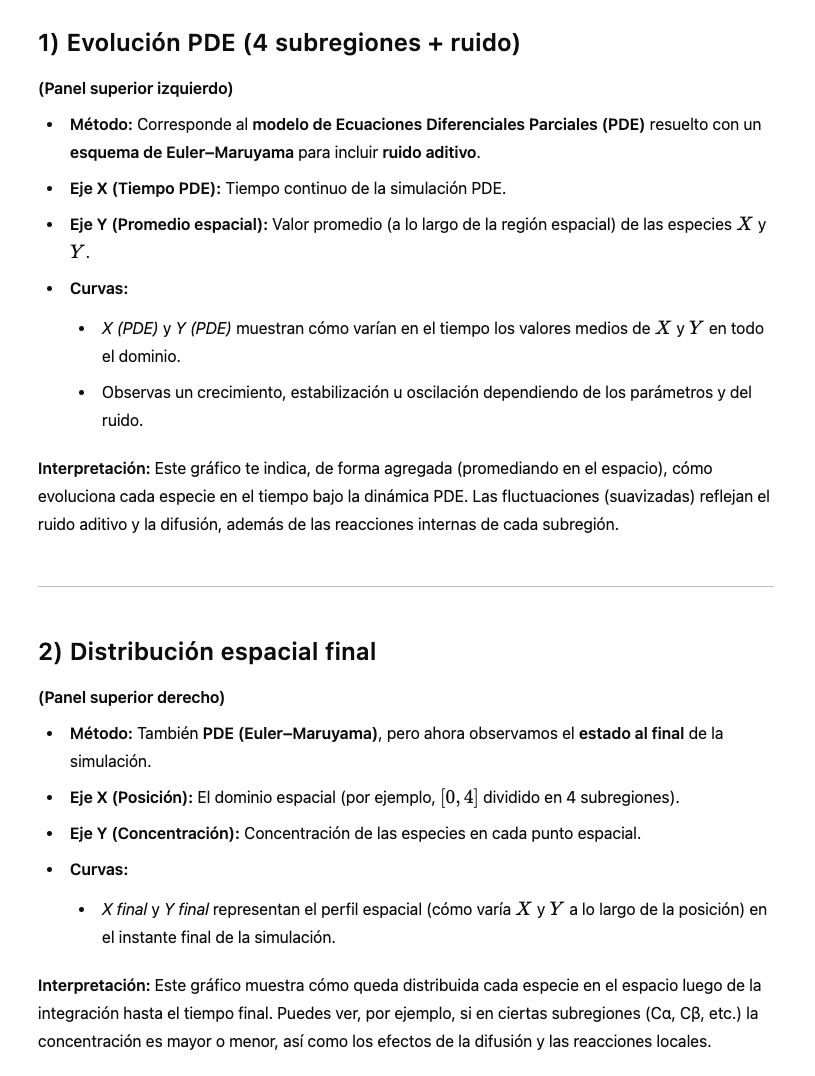

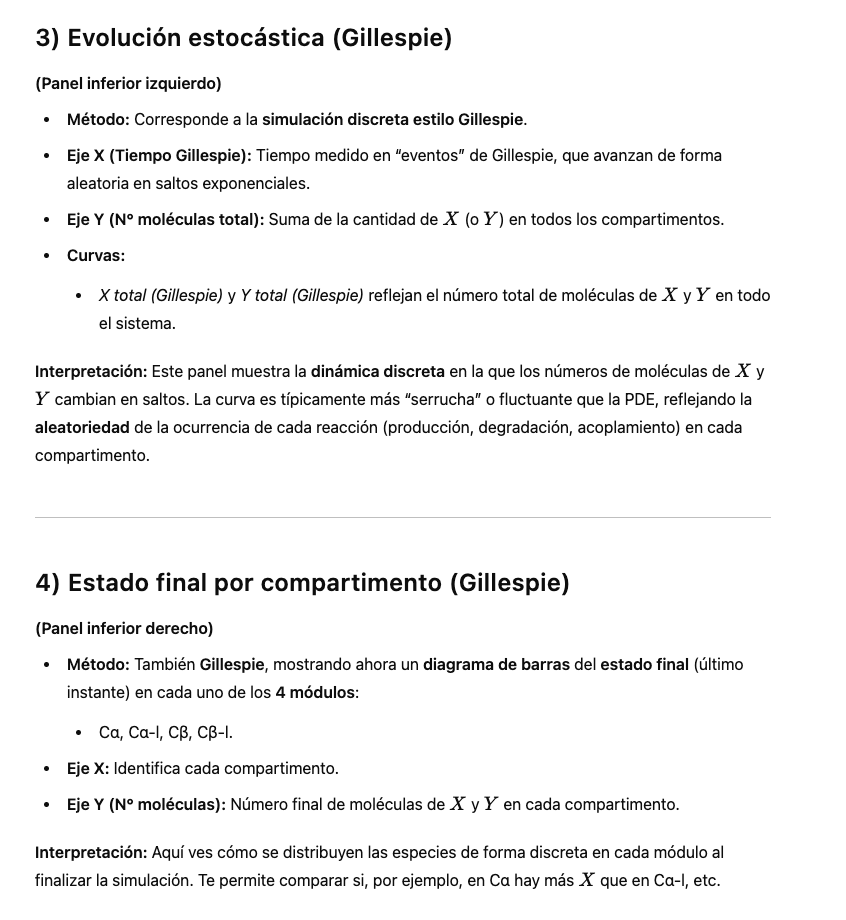